# Image Classifier

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [25]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [26]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4, shuffle=False, num_workers=2)

0it [00:00, ?it/s]

 99%|█████████▉| 169631744/170498071 [00:16<00:00, 11432555.73it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


170500096it [00:30, 11432555.73it/s]                               

In [27]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize Data

(3, 36, 138)


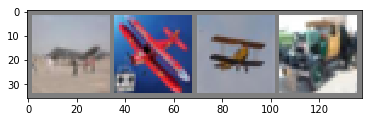

plane plane plane truck


In [91]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Defining a CNN

In [81]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,25,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(25,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Pass network to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
net.to(device)

Net(
  (conv1): Conv2d(3, 25, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(25, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Defining a Loss function and Optimizer

In [82]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the Network

In [83]:
for epoch in range(2):
    
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training!')

[1,  2000] loss: 2.160
[1,  4000] loss: 1.775
[1,  6000] loss: 1.598
[1,  8000] loss: 1.514
[1, 10000] loss: 1.453
[1, 12000] loss: 1.409
[2,  2000] loss: 1.311
[2,  4000] loss: 1.298
[2,  6000] loss: 1.271
[2,  8000] loss: 1.231
[2, 10000] loss: 1.228
[2, 12000] loss: 1.181
Finished Training!


In [84]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test Network on Data

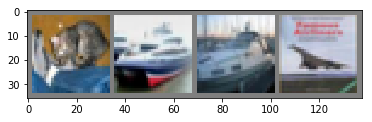

GroundTruth:    cat  ship  ship plane


In [85]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [86]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [87]:
output = net(images)
_, predicted = torch.max(output,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


In [88]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [89]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 72 %
Accuracy of  bird : 31 %
Accuracy of   cat : 37 %
Accuracy of  deer : 66 %
Accuracy of   dog : 36 %
Accuracy of  frog : 71 %
Accuracy of horse : 70 %
Accuracy of  ship : 68 %
Accuracy of truck : 73 %
